# Linear Regression Example with JAX
This example performs linear regression on simulated data. Specifically, the model we will fit is $y = m_tx + b_t + \epsilon$, where $\epsilon \sim N(0,\sigma)$.  

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax

First, let's simulate some test data and plot it.

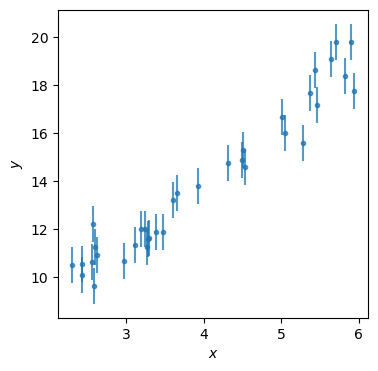

In [3]:
n = 35
x = np.random.rand(n) * 4. + 2.
mt = 2.5
bt = 4. 
sigma = 0.75
err = np.random.randn(n) * sigma
y = mt * x + bt + err

plt.figure(figsize=(4, 4))
plt.errorbar(x, y, yerr=sigma, ls='', marker='.', alpha=0.75)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

The model we will train is $\hat{y}(x|m,b)=mx + b$, which has two parameters: $m$ and $b$. Let's group these parameters into a vector $\theta=[m,b]$. We are going to optimize a loss function $f(\hat{y}_{\mathbf{\theta}}, y)$ with respect to $\theta$, so the model function we define should have for its first argument said parameter vector $\theta$.

In [4]:
def model(theta, x):
    return theta[0] * x + theta[1] 

# Let's just use basic quadratic loss function. 
def loss_fn(theta, x, y):
    yhat = model(theta, x)
    del_y = y - yhat
    return jnp.mean(del_y**2)


To optimize requires an optimization scheme --- that is, a way to update the parameter estimates to minimize the loss. We will use gradient descent to do this.  Each step in this optimization recipe will update parameters as follows: $\theta_{i + 1}= \theta_{i} - \alpha\nabla f(\theta, x, y)$.  
Here $\alpha$ is the learning rate, which we will set to $\alpha=0.01$.

In [6]:
def opt_step(theta, x, y, alpha):
    return theta - alpha * jax.grad(loss_fn)(theta, x, y)

Now, let's initialize some initial conditions for our parameters.  Let's assume we are totally ignorant to the parameters' true values apart from knowing they are roughly of order unity: $\theta_0=[1,1]$.  We'll next iterate until we converge to a solution for $\theta$. 

In [7]:
theta = jnp.array([1., 1.])

def fit(theta, x, y, alpha=0.01, tolerance=1e-3, max_iter=5000):
    i = 0
    theta_old = jnp.copy(theta)
    while True:
        theta_new = opt_step(theta_old, x, y, alpha)
        
        # Let's also set a tolerance to finish at and maximum iteration 
        # if convergence is not reached.  
        if (jnp.abs(theta_new - theta_old) < tolerance).all():
            break
        
        else:
            i += 1
            if i == max_iter:
                print(f'Maximum iteration of {max_iter} reached without convergence.')
                break
            
            else:
                theta_old = theta_new.copy() # replace in memory old theta value with updated one
    return theta_new

%timeit fit(theta, x, y).block_until_ready()
theta_hat = fit(theta, x, y)


3.21 s ± 49.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


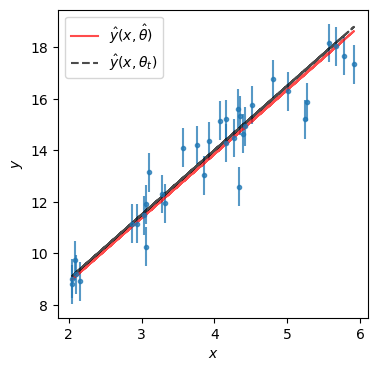

In [72]:
x_arr = np.array([x[0] * 0.8, x[-1] * 1.2])

plt.figure(figsize=(4, 4))
plt.errorbar(x, y, yerr=sigma, ls='', marker='.', alpha=0.75)
plt.plot(
    x, theta_hat[0] * x + theta_hat[1],
    label=r'$\hat{y}(x, \hat{\theta})$', color='red', alpha=0.7
)
plt.plot(
    x, mt * x + bt,
    label=r'$\hat{y}(x, \theta_t)$', color='black', alpha=0.7, ls='--'
)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.legend()
plt.show()

# Just In Time (JIT) Compilation with JAX
We can improve the performance of JAX-compatible functions using `jax.jit` to compile pure functions that have no conditionals.  This means that if a function `func` 1) only acts on an output object and 2) has not conditional comparison (no if-else or while statements), then `func_jit = jax.jit(func)` will very likely provide a noticeably faster calculation. 

If condition 1) is not satisfied, `jax.jit(func)` might still work without a guarantee of preserving all expected functionlity.  Violating condition 2) will break any attempt to `jax.jit(func)`, though!

Let's JIT-ify the functions we can. Becaues of its conditional statements, we only recode `fit` to use JIT-ified functions.  As you'll hopefully see, `jax.jit` provides a convenient transformation that can dramatically increase efficiency. 

In [8]:
model_jit = jax.jit(model)
loss_fn_jit = jax.jit(loss_fn)
opt_step_jit = jax.jit(opt_step) # We really only need to JIT-ify this function.

theta0 = jnp.array([1., 1.])

# This compiles opt_step_jit before we call it to make the timeit statement a
# fair comparison to the one above. 
opt_step_jit(theta0, jnp.array([1., 2.]), jnp.array([1., 2.]), 0.01)

def fit_jit(theta, x, y, alpha=0.01, tolerance=1e-3, max_iter=5000):
    i = 0
    theta_old = jnp.copy(theta)
    while True:
        theta_new = opt_step_jit(theta_old, x, y, alpha)
        
        # Let's also set a tolerance to finish at and maximum iteration 
        # if convergence is not reached.  
        if (jnp.abs(theta_new - theta_old) < tolerance).all():
            break
        
        else:
            i += 1
            if i == max_iter:
                print(f'Maximum iteration of {max_iter} reached without convergence.')
                break
            
            else:
                theta_old = theta_new.copy() # replace in memory old theta value with updated one
    return theta_new

%timeit fit_jit(theta, x, y).block_until_ready()
theta_hat_jit = fit_jit(theta, x, y)


93.8 ms ± 1.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


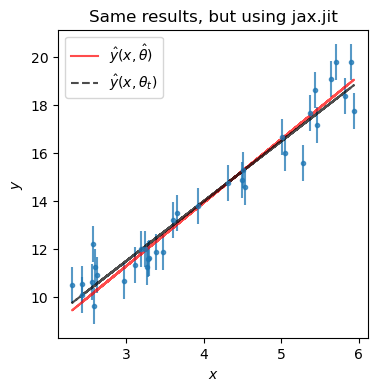

In [9]:
x_arr = np.array([x[0] * 0.8, x[-1] * 1.2])

plt.figure(figsize=(4, 4))
plt.errorbar(x, y, yerr=sigma, ls='', marker='.', alpha=0.75)
plt.plot(
    x, theta_hat_jit[0] * x + theta_hat_jit[1],
    label=r'$\hat{y}(x, \hat{\theta})$', color='red', alpha=0.7
)
plt.plot(
    x, mt * x + bt,
    label=r'$\hat{y}(x, \theta_t)$', color='black', alpha=0.7, ls='--'
)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.legend()
plt.title('Same results, but using jax.jit')
plt.show()

## When to Use JIT
You don't want to JIT-ify everything.  The precompilation adds overhead, so unless the function to be JIT-ified is being called many times, JIT-ifying will actually slow down your code.  The reason it worked in this example is because `opt_step` is being called hundreds of times, so having it compiled meant the initial additional overhead was completely outweighed by the speed increase for each call.  

Long story short: if you have a JIT-ifiable function, you only should JIT-ify it if the function is going to be called multiple times.  